# * Before you start, please make a copy to your drive or elsewhere *

## Setup environments

In [8]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
print("torch-scatter installed")
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
print("torch-sparse installed")
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
print("torch-geometric installed")

!pip install ogb

1.12.0
torch-scatter installed
torch-sparse installed
torch-geometric installed
Looking in indexes: https://pypi.org/simple/


## Load the OGB dataset
See details: https://ogb.stanford.edu/docs/nodeprop/#ogbn-arxiv

In [9]:
import torch_geometric.transforms as T
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import Evaluator

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name)
data = dataset[0]

# convert into a networkx object
g = to_networkx(data = data, to_undirected=True)


## (3 points) Check the number of nodes, edges and density of the graph

In [2]:
## -- your code here -- ##
## calculate the number of nodes, edges and density of the graph g
## you can use networkX library

num_nodes = g.number_of_nodes()
num_edges = g.number_of_edges()
density = 2*num_edges/(num_nodes*(num_nodes-1))

print('Number of nodes: %d, number of edges: %d, density: %g'%(num_nodes, num_edges, density))

Number of nodes: 169343, number of edges: 570407, density: 3.97817e-05


##(5 points) Plot the degree distribution of the graph

<Figure size 1200x800 with 0 Axes>

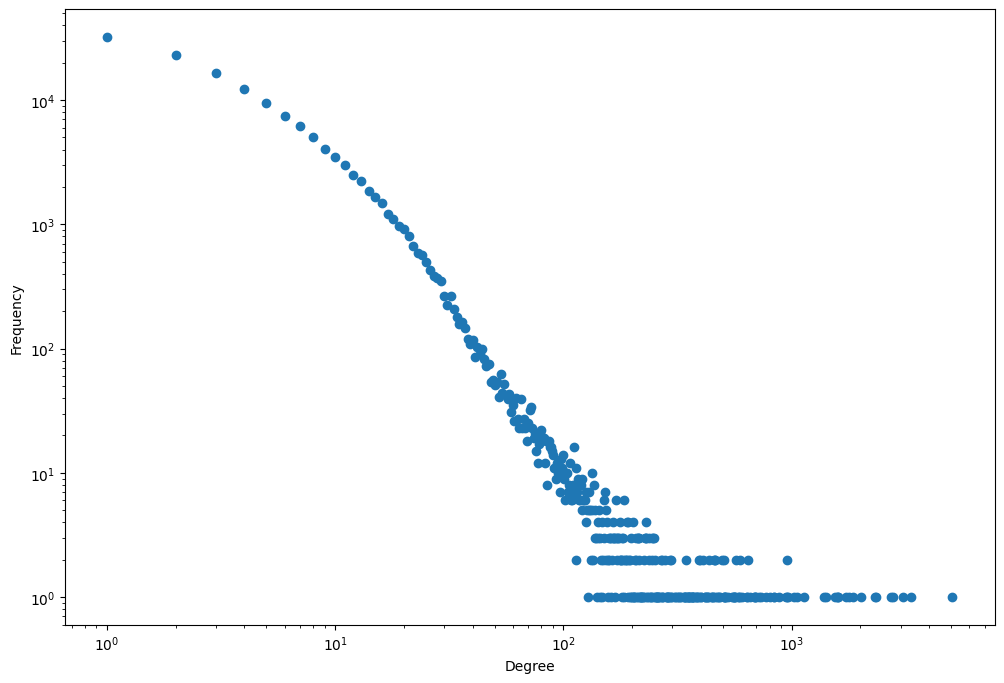

In [3]:
import matplotlib.pyplot as plt
def plot_degree_hist(G):
  freq = nx.degree_histogram(G)

  plt.figure(figsize=(12,8))
  
  ## -- your code here -- ##
  ## It should be a log-log scale plot
  ## (x-axis: node degree, y-axis: degree frequency)

  degree = range(len(freq))
  plt.figure(figsize=(12, 8)) 
  plt.loglog(degree, freq,'o') 
  
  plt.xlabel('Degree')
  plt.ylabel('Frequency')

plot_degree_hist(g)

## (5 points) Compute the network diameter

In [4]:
def compute_diameter(G, approx=True):

  ## -- your code here -- ##
  ## If a graph is connected, you just use nx.diameter(.)
  ## If a graph is disconnected, you first extract the largest connected component as subgraph and compute the diameter of it
  ## 
  ## NetworkX functions will be useful such as nx.is_connected(.), nx.connected_components(.), nx.diameter(.)
  ## See https://networkx.org/documentation/stable/reference/algorithms/index.html
  ##
  ## For a large graph, approximations can be helpful (nx.approximation.diameter(.))
  ## See https://networkx.org/documentation/stable/reference/algorithms/approximation.html

  if nx.is_connected(G):
    if approx:
      diameter = nx.approximation.diameter(G)

    else:
      diameter = nx.diameter(G)

  else:
    largest_cc = max(nx.connected_components(G), key=len)
    c = G.subgraph(largest_cc).copy()
    if approx:
      diameter = nx.approximation.diameter(c)
    
    else:
      diameter = nx.diameter(c)


  return diameter

print(compute_diameter(g))

30


##Prepare your dataset

In [10]:
# transform into a sparse tensor
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor())

data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

print(data)

cuda
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])


## Model design
To investigate GNN-based models can improve the prediction performance, we first implement a simple MLP(Multi-layer Perceptron) model as below.

## (10 points) Complete the forward function

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, num_layers, dp_rate):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super(MLP, self).__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                torch.nn.Linear(in_channels, out_channels)
            ]
            in_channels = c_hidden
        layers += [torch.nn.Linear(in_channels, c_out)]
        self.layers = torch.nn.Sequential(*layers)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dp_rate

    def forward(self, x):

      ## --- your code here --- ##
      ## For each layer (use self.layers), add ReLU activation (torch.nn.functional.relu) and 
      ##   dropout (torch.nn.functional.dropout) when it is in training mode (you can use self.training)
      ## See https://pytorch.org/docs/stable/nn.functional.html
      ## return output ('out') after the softmax layer (use self.softmax)

      for layer in self.layers:
        x = layer(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        #x = F.normalize(x, p=2., dim=-1)
      out = self.softmax(x)

      return out

Now, train and test the model

## (7 points) Complete the train / test function

In [13]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()

    #out[idx_train], labels[idx_train]

    ## fill in the parameters of each function
    out = model(data.x)
    #print(out)
    #print(data.y[train_idx])
    loss = loss_fn(out[train_idx], data.y.squeeze(1)[train_idx])
    
    loss.backward()
    optimizer.step()

    return loss.item()

def test(model, data, split_idx, evaluator):
    model.eval()

    ## fill in the parameters 
    out = model(data.x)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [14]:
import copy

loss_mlp = []
train_acc_mlp = []
val_acc_mlp = []
test_acc_mlp = []

args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

model = MLP(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss
evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, data, train_idx, optimizer, loss_fn)
  loss_mlp.append(loss)
  result = test(model, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result

  train_acc_mlp.append(train_acc)
  val_acc_mlp.append(valid_acc)
  test_acc_mlp.append(test_acc)


  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

best_result = test(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result

print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.6891, Train: 11.03%, Valid: 22.98% Test: 21.56%
Epoch: 04, Loss: 3.4599, Train: 25.96%, Valid: 29.03% Test: 25.88%
Epoch: 15, Loss: 3.4810, Train: 24.55%, Valid: 29.43% Test: 26.62%
Epoch: 16, Loss: 3.4634, Train: 27.94%, Valid: 30.87% Test: 27.79%
Epoch: 17, Loss: 3.4381, Train: 28.48%, Valid: 31.19% Test: 28.70%
Epoch: 28, Loss: 3.2818, Train: 30.72%, Valid: 31.77% Test: 29.19%
Epoch: 29, Loss: 3.2811, Train: 31.67%, Valid: 33.04% Test: 30.69%
Epoch: 30, Loss: 3.2632, Train: 32.52%, Valid: 34.11% Test: 32.00%
Epoch: 31, Loss: 3.2575, Train: 33.20%, Valid: 34.78% Test: 32.83%
Epoch: 32, Loss: 3.2440, Train: 33.88%, Valid: 35.86% Test: 33.92%
Epoch: 33, Loss: 3.2368, Train: 34.61%, Valid: 37.19% Test: 35.17%
Epoch: 34, Loss: 3.2230, Train: 35.85%, Valid: 38.89% Test: 37.13%
Epoch: 35, Loss: 3.2223, Train: 36.99%, Valid: 40.44% Test: 39.06%
Epoch: 36, Loss: 3.2137, Train: 37.73%, Valid: 41.47% Test: 40.19%
Epoch: 37, Loss: 3.1956, Train: 38.06%, Valid: 41.83% Test: 40



##Q1. (30 points) Submit the completed notebook file (File > Download > Download .ipynb)




#Submit the document (.docx) that answer the following questions. <br> 
###**- For the following questions, you should include the modified or added part of your code in Q1.** <br><br>


## GNN model
Now, you will design GNN model and evaluate the prediction performance as above. <br>
Write down your code below and train the model using the same parameters (args.num_layers, args_dropout, etc.). <br>
You can use PyG library for GCN and GraphSAGE operater (https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) as below. <br><br>




In [15]:
from torch_geometric.nn import GCNConv, SAGEConv
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn

class GNN(MessagePassing):
    def __init__(self, c_in, c_hidden, c_out, num_layers, dp_rate):
        
        super(GNN, self).__init__(aggr='mean')
        
        # --- Your code here --- #
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels)
            ]
            in_channels = c_hidden
        layers += [torch.nn.Linear(in_channels, c_out)]
        self.layers = torch.nn.Sequential(*layers)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        self.dropout = dp_rate
        self.n_layers = len(layers)

    def forward(self, x, adj_t):
      # --- Your code here --- #
      x = self.propagate(adj_t, x=x, size=None)
      x = self.layers[0](x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)

      for i in range(self.n_layers-1):
        x = self.propagate(adj_t, x=x, size=None)
        x = self.layers[i+1](x)

      # for layer in self.layers:
      #   x = self.propagate(adj_t, x=x)
      #   x = layer(x)
      #   x = F.relu(x)
      #   x = F.dropout(x, p=self.dropout, training=self.training)
      #   #x = self.propagate(adj_t, x=x)
      #   x = F.normalize(x)

        
      out = self.softmax(x)
      return out

ImportError: cannot import name 'dropout_edge' from 'torch_geometric.utils' (/home/ubuntu/anaconda3/envs/bethel_env_gnn_39/lib/python3.9/site-packages/torch_geometric/utils/__init__.py)

In [79]:
def train_GNN(model, data, train_idx, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()

    ## fill in the parameters of each function

    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y.squeeze(1)[train_idx])
    
    loss.backward()
    optimizer.step()

    return loss.item()

def test_GNN(model, data, split_idx, evaluator):
    model.eval()

    ## fill in the parameters 
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

In [92]:
loss_gnn = []
train_acc_gnn = []
val_acc_gnn = []
test_acc_gnn = []

args_GNN = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 235,
    'dropout': 0.2711,
    'lr': 0.017914,
    'epochs': 100,
}

model_GNN = GNN(data.num_features, args_GNN['hidden_dim'],
            dataset.num_classes, args_GNN['num_layers'],
            args_GNN['dropout']).to(device)

optimizer_GNN = torch.optim.Adam(model_GNN.parameters(), lr=args_GNN['lr'])
loss_fn = F.nll_loss
evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

#to measure the execution time
start_time = time.time()

for epoch in range(1, 1 + args_GNN["epochs"]):
  loss = train_GNN(model_GNN, data, split_idx['train'], optimizer_GNN, loss_fn)
  loss_gnn.append(loss)

  result = test_GNN(model_GNN, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  
  train_acc_gnn.append(train_acc)
  val_acc_gnn.append(valid_acc)
  test_acc_gnn.append(test_acc)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model_GNN)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%',
      f'Exec. Time: {(time.time() - start_time) :.5f} sec')

Epoch: 01, Loss: 3.6815, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 02, Loss: 3.3488, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 04, Loss: 3.3362, Train: 11.02%, Valid: 22.99% Test: 21.56%
Epoch: 05, Loss: 3.2159, Train: 11.26%, Valid: 23.11% Test: 21.61%
Epoch: 06, Loss: 3.1230, Train: 28.17%, Valid: 30.22% Test: 27.11%
Epoch: 08, Loss: 2.9239, Train: 28.21%, Valid: 30.24% Test: 27.07%
Epoch: 10, Loss: 2.7984, Train: 29.53%, Valid: 31.61% Test: 29.24%
Epoch: 11, Loss: 2.6136, Train: 30.91%, Valid: 32.04% Test: 29.61%
Epoch: 12, Loss: 2.5631, Train: 31.30%, Valid: 32.93% Test: 30.61%
Epoch: 13, Loss: 2.4821, Train: 32.99%, Valid: 33.59% Test: 31.03%
Epoch: 14, Loss: 2.3466, Train: 37.37%, Valid: 36.18% Test: 32.51%
Epoch: 15, Loss: 2.3171, Train: 39.01%, Valid: 37.82% Test: 34.68%
Epoch: 16, Loss: 2.2079, Train: 41.33%, Valid: 45.84% Test: 44.45%
Epoch: 17, Loss: 2.1672, Train: 43.58%, Valid: 47.58% Test: 46.55%
Epoch: 20, Loss: 1.9693, Train: 47.10%, Valid: 48.41% Test: 46.9

## Loss curve comparison - GNN and MLP

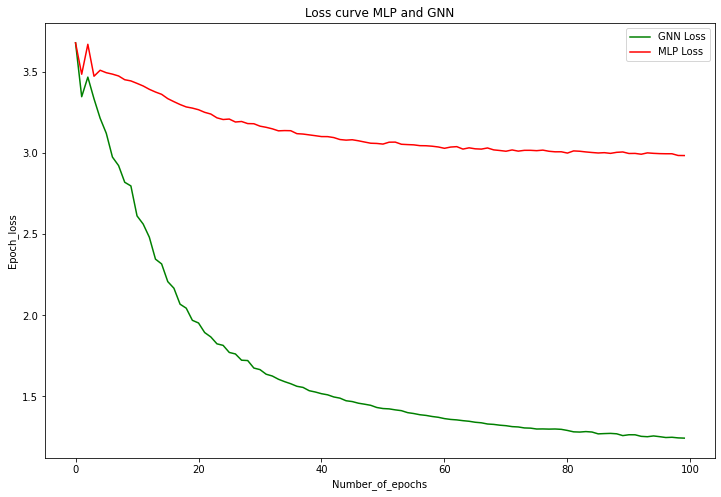

In [105]:
plt.figure(figsize=(12, 8))  
plt.xlabel('Number_of_epochs')
plt.ylabel('Epoch_loss')
plt.title('Loss curve MLP and GNN')

plt.plot(loss_gnn, color = 'g', label = 'GNN Loss')
plt.plot(loss_mlp, color = 'r', label = 'MLP Loss')
plt.legend()
plt.savefig('Desktop\\ATIML_Loss-curve.jpg', bbox_inches = 'tight', dpi  = 600)

## Accuracy curve of both models

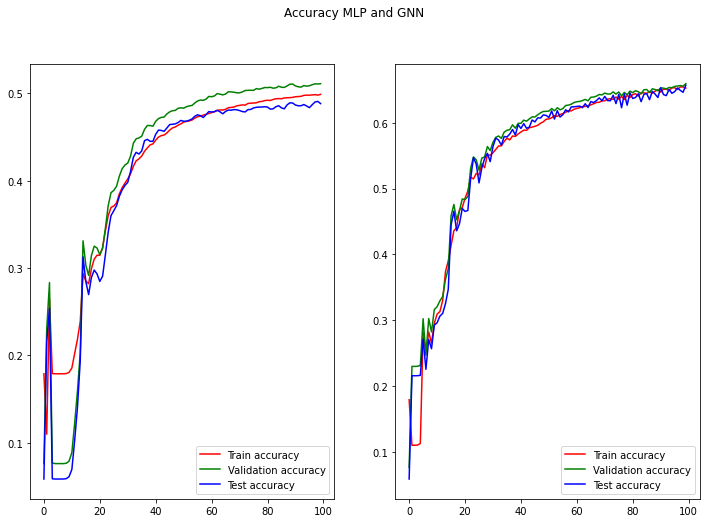

In [106]:
plt.figure(figsize=(12, 8)) 
plt.xlabel('Number_of_epochs')
plt.ylabel('accuracy')

plt.subplot(1,2,1)
plt.suptitle('Accuracy MLP and GNN')
plt.plot(train_acc_mlp, color = 'r', label = 'Train accuracy')
plt.plot(val_acc_mlp, color = 'g', label = 'Validation accuracy')
plt.plot(test_acc_mlp, color = 'b', label = 'Test accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_gnn, color = 'r', label = 'Train accuracy')
plt.plot(val_acc_gnn, color = 'g', label = 'Validation accuracy')
plt.plot(test_acc_gnn, color = 'b', label = 'Test accuracy')
plt.legend()
plt.savefig('Desktop\\ATIML_accuracy.jpg', bbox_inches = 'tight', dpi  = 600)


## Performance after hyperparametre-tuning

In [95]:
loss_gnn2 = []
train_acc_gnn2 = []
val_acc_gnn2 = []
test_acc_gnn2 = []

args_GNN = {
    'device': device,
    'num_layers': 10,
    'hidden_dim': 256,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

model_GNN = GNN(data.num_features, args_GNN['hidden_dim'],
            dataset.num_classes, args_GNN['num_layers'],
            args_GNN['dropout']).to(device)

optimizer_GNN = torch.optim.Adam(model_GNN.parameters(), lr=args_GNN['lr'])
loss_fn = F.nll_loss
evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args_GNN["epochs"]):
  loss = train_GNN(model_GNN, data, split_idx['train'], optimizer_GNN, loss_fn)
  loss_gnn2.append(loss)

  result = test_GNN(model_GNN, data, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  
  train_acc_gnn2.append(train_acc)
  val_acc_gnn2.append(valid_acc)
  test_acc_gnn2.append(test_acc)

  if valid_acc > best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model_GNN)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.6747, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 03, Loss: 85.0556, Train: 10.99%, Valid: 22.97% Test: 21.56%
Best model: Train: 10.99%, Valid: 22.97% Test: 21.56%


## GraphSage implementation (Note: the source code for the GraphSage class is mostly taken from  https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/sage_conv.html#SAGEConv, and modified)

In [98]:
from typing import List, Optional, Tuple, Union

import torch.nn.functional as F
from torch import Tensor
from torch.nn import LSTM
from torch_sparse import SparseTensor, matmul

from torch_geometric.nn.aggr import Aggregation, MultiAggregation
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptPairTensor, Size


class SAGEConv3(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: Optional[Union[str, List[str], Aggregation]] = "mean",
        normalize: bool = False,
        root_weight: bool = True,
        project: bool = False,
        bias: bool = True,
        **kwargs,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight
        self.project = project

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        if aggr == 'lstm':
            kwargs.setdefault('aggr_kwargs', {})
            kwargs['aggr_kwargs'].setdefault('in_channels', in_channels[0])
            kwargs['aggr_kwargs'].setdefault('out_channels', in_channels[0])

        super().__init__(aggr, **kwargs)

        if self.project:
            self.lin = Linear(in_channels[0], in_channels[0], bias=True)

        if self.aggr is None:
            self.fuse = False 
            self.lstm = LSTM(in_channels[0], in_channels[0], batch_first=True)

        if isinstance(self.aggr_module, MultiAggregation):
            aggr_out_channels = self.aggr_module.get_out_channels(
                in_channels[0])
        else:
            aggr_out_channels = in_channels[0]

        self.lin_l = Linear(aggr_out_channels, out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

        self.softmax = torch.nn.LogSoftmax(dim=1)

    def reset_parameters(self):
        if self.project:
            self.lin.reset_parameters()
        self.aggr_module.reset_parameters()
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        if self.project and hasattr(self, 'lin'):
            x = (self.lin(x[0]).relu(), x[1])

        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out = out + self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return self.softmax(out)

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, aggr={self.aggr})')


In [99]:
def train_GSage(model, data, train_idx, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()

    ## fill in the parameters of each function

    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y.squeeze(1)[train_idx])
    
    loss.backward()
    optimizer.step()

    return loss.item()

def test_GSage(model, data, split_idx, evaluator):
    model.eval()

    ## fill in the parameters 
    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

## Performance using the "mean" *aggregator*

In [100]:
import time

args_SAGE = {
    'device': device,
    'num_layers': 3,
    'lr': 0.01,
    'epochs': 100,
}

#model_SAGE = SAGEConv(data.num_features, dataset.num_classes, aggr = args_SAGE['aggr'] ).to(device)

model_SAGE = SAGEConv3(data.num_features, dataset.num_classes).to(device)

optimizer_SAGE = torch.optim.Adam(model_SAGE.parameters(), lr=args_SAGE['lr'])
loss_fn = F.nll_loss

evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

start_time = time.time()

for epoch in range(1, 1 + args_SAGE["epochs"]):
      loss = train_GNN(model_SAGE, data, split_idx['train'], optimizer_SAGE, loss_fn)

      result = test_GNN(model_SAGE, data, split_idx, evaluator)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model_SAGE)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%',
              f'Exec. Time: {(time.time() - start_time) :.5f} sec')

Epoch: 01, Loss: 3.7113, Train: 13.52%, Valid: 6.71% Test: 5.49%
Epoch: 02, Loss: 3.4042, Train: 17.20%, Valid: 8.09% Test: 6.77%
Epoch: 03, Loss: 3.1932, Train: 17.84%, Valid: 8.14% Test: 6.76%
Epoch: 06, Loss: 2.9123, Train: 18.28%, Valid: 8.17% Test: 6.32%
Epoch: 07, Loss: 2.8704, Train: 19.13%, Valid: 9.84% Test: 7.70%
Epoch: 08, Loss: 2.8363, Train: 20.62%, Valid: 13.27% Test: 10.73%
Epoch: 09, Loss: 2.8015, Train: 22.35%, Valid: 17.44% Test: 14.57%
Epoch: 10, Loss: 2.7615, Train: 23.96%, Valid: 21.09% Test: 17.95%
Epoch: 11, Loss: 2.7164, Train: 25.32%, Valid: 23.73% Test: 20.71%
Epoch: 12, Loss: 2.6692, Train: 26.53%, Valid: 25.74% Test: 22.80%
Epoch: 13, Loss: 2.6230, Train: 28.06%, Valid: 27.84% Test: 24.83%
Epoch: 14, Loss: 2.5803, Train: 30.35%, Valid: 30.49% Test: 27.46%
Epoch: 15, Loss: 2.5414, Train: 33.59%, Valid: 34.17% Test: 31.34%
Epoch: 16, Loss: 2.5056, Train: 37.08%, Valid: 38.44% Test: 36.06%
Epoch: 17, Loss: 2.4713, Train: 39.47%, Valid: 42.16% Test: 40.39%
Epoch

## Performance using the "min" *aggregator*

In [38]:
import time

args_SAGE = {
    'device': device,
    'num_layers': 3,
    'lr': 0.01,
    'epochs': 100,
}

#model_SAGE = SAGEConv(data.num_features, dataset.num_classes, aggr = args_SAGE['aggr'] ).to(device)

model_SAGE = SAGEConv3(data.num_features, dataset.num_classes).to(device)

optimizer_SAGE = torch.optim.Adam(model_SAGE.parameters(), lr=args_SAGE['lr'])
loss_fn = F.nll_loss

evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

start_time = time.time()

for epoch in range(1, 1 + args_SAGE["epochs"]):
      loss = train_GNN(model_SAGE, data, split_idx['train'], optimizer_SAGE, loss_fn)

      result = test_GNN(model_SAGE, data, split_idx, evaluator)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model_SAGE)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%',
              f'Exec. Time: {(time.time() - start_time) :.5f} sec')

Epoch: 01, Loss: 3.7506, Train: 12.00%, Valid: 17.63% Test: 16.66%
Epoch: 02, Loss: 3.4041, Train: 13.97%, Valid: 22.89% Test: 21.83%
Epoch: 03, Loss: 3.1727, Train: 15.22%, Valid: 24.36% Test: 22.72%
Epoch: 04, Loss: 3.0253, Train: 17.83%, Valid: 24.85% Test: 23.20%
Epoch: 05, Loss: 2.9354, Train: 22.94%, Valid: 26.39% Test: 24.62%
Epoch: 14, Loss: 2.5657, Train: 29.04%, Valid: 27.05% Test: 25.01%
Epoch: 15, Loss: 2.5291, Train: 32.37%, Valid: 31.07% Test: 28.66%
Epoch: 16, Loss: 2.4944, Train: 35.00%, Valid: 34.12% Test: 31.38%
Epoch: 17, Loss: 2.4602, Train: 36.80%, Valid: 36.45% Test: 33.51%
Epoch: 18, Loss: 2.4259, Train: 37.98%, Valid: 38.09% Test: 35.24%
Epoch: 19, Loss: 2.3920, Train: 38.74%, Valid: 39.24% Test: 36.77%
Epoch: 20, Loss: 2.3586, Train: 39.28%, Valid: 40.15% Test: 38.08%
Epoch: 21, Loss: 2.3262, Train: 39.58%, Valid: 40.84% Test: 39.01%
Epoch: 22, Loss: 2.2946, Train: 39.92%, Valid: 41.32% Test: 39.69%
Epoch: 23, Loss: 2.2638, Train: 40.36%, Valid: 41.82% Test: 40

## Performance using the "max" *aggregator*

In [42]:
args_SAGE = {
    'device': device,
    'num_layers': 3,
    'lr': 0.01,
    'epochs': 100,
}

#model_SAGE = SAGEConv(data.num_features, dataset.num_classes, aggr = args_SAGE['aggr'] ).to(device)

model_SAGE = SAGEConv3(data.num_features, dataset.num_classes).to(device)

optimizer_SAGE = torch.optim.Adam(model_SAGE.parameters(), lr=args_SAGE['lr'])
loss_fn = F.nll_loss

evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args_SAGE["epochs"]):
      loss = train_GNN(model_SAGE, data, split_idx['train'], optimizer_SAGE, loss_fn)

      result = test_GNN(model_SAGE, data, split_idx, evaluator)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model_SAGE)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.7395, Train: 11.17%, Valid: 22.09% Test: 20.80%
Epoch: 02, Loss: 3.3924, Train: 11.56%, Valid: 23.11% Test: 21.82%
Epoch: 04, Loss: 3.0438, Train: 14.48%, Valid: 23.96% Test: 22.22%
Epoch: 05, Loss: 2.9660, Train: 22.97%, Valid: 25.22% Test: 22.75%
Epoch: 14, Loss: 2.5935, Train: 29.68%, Valid: 29.44% Test: 28.01%
Epoch: 15, Loss: 2.5579, Train: 32.96%, Valid: 33.63% Test: 31.40%
Epoch: 16, Loss: 2.5239, Train: 34.78%, Valid: 35.40% Test: 32.71%
Epoch: 17, Loss: 2.4901, Train: 35.61%, Valid: 36.12% Test: 32.97%
Epoch: 18, Loss: 2.4557, Train: 35.98%, Valid: 36.38% Test: 33.03%
Epoch: 19, Loss: 2.4208, Train: 36.35%, Valid: 36.70% Test: 33.52%
Epoch: 20, Loss: 2.3860, Train: 36.96%, Valid: 37.26% Test: 34.51%
Epoch: 21, Loss: 2.3519, Train: 37.72%, Valid: 38.33% Test: 36.11%
Epoch: 22, Loss: 2.3190, Train: 38.32%, Valid: 39.42% Test: 37.85%
Epoch: 23, Loss: 2.2875, Train: 38.83%, Valid: 40.72% Test: 39.54%
Epoch: 24, Loss: 2.2577, Train: 39.21%, Valid: 41.61% Test: 40

## Performance using the "Add" *aggregator*

In [53]:
args_SAGE = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'lr': 0.01,
    'epochs': 100,
}

#model_SAGE = SAGEConv(data.num_features, dataset.num_classes, aggr = args_SAGE['aggr'] ).to(device)

model_SAGE = SAGEConv3(data.num_features, dataset.num_classes).to(device)

optimizer_SAGE = torch.optim.Adam(model_SAGE.parameters(), lr=args_SAGE['lr'])
loss_fn = F.nll_loss

evaluator = Evaluator(name='ogbn-arxiv')

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args_SAGE["epochs"]):
      loss = train_GNN(model_SAGE, data, split_idx['train'], optimizer_SAGE, loss_fn)

      result = test_GNN(model_SAGE, data, split_idx, evaluator)
      train_acc, valid_acc, test_acc = result
      if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_model = copy.deepcopy(model_SAGE)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

best_result = test_GNN(best_model, data, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 5.5136, Train: 8.97%, Valid: 15.31% Test: 22.26%
Epoch: 02, Loss: 4.4524, Train: 23.40%, Valid: 23.07% Test: 20.45%
Epoch: 03, Loss: 3.5238, Train: 26.04%, Valid: 28.92% Test: 26.29%
Epoch: 06, Loss: 4.1008, Train: 31.82%, Valid: 32.65% Test: 29.83%
Epoch: 14, Loss: 2.9871, Train: 32.19%, Valid: 33.12% Test: 35.37%
Epoch: 15, Loss: 2.7477, Train: 33.71%, Valid: 36.25% Test: 34.05%
Epoch: 16, Loss: 2.6836, Train: 36.97%, Valid: 39.21% Test: 36.31%
Epoch: 17, Loss: 2.7399, Train: 40.18%, Valid: 40.83% Test: 37.70%
Epoch: 18, Loss: 2.7711, Train: 43.16%, Valid: 42.67% Test: 39.35%
Epoch: 19, Loss: 2.7231, Train: 45.34%, Valid: 44.91% Test: 42.18%
Epoch: 20, Loss: 2.6069, Train: 45.67%, Valid: 46.73% Test: 45.54%
Epoch: 21, Loss: 2.4736, Train: 45.30%, Valid: 48.48% Test: 49.64%
Epoch: 29, Loss: 2.1551, Train: 50.75%, Valid: 50.59% Test: 48.87%
Epoch: 30, Loss: 2.0919, Train: 51.88%, Valid: 53.22% Test: 52.60%
Epoch: 31, Loss: 2.0370, Train: 52.01%, Valid: 54.39% Test: 54.


##Q2. (20 points) How was the prediction performance of GCN model? Compare with MLP model and discuss about the results. <br><br>

##Q3. (20 points) How was the prediction performance of GraphSAGE? Use different aggregation function (use parameter 'aggr' in SAGEConv) and compare the performances. Discuss about the results. <br><br>

##Q4. (20 points) For a GCN model, change the number of layers (args.num_layers) into 10. How is the performance now? Discuss about the results. <br><br>

##Q5. (10 points) Suggest your strategy to improve the performance. Hint: You can use the building blocks for DNN as we learned in our class (Refer https://pytorch.org/docs/stable/nn.html). <br><br>